# Fuck Score-based Generative Model (SGM)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

/home/liujiarun/anaconda3/envs/omniglue/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1, 28, 28])


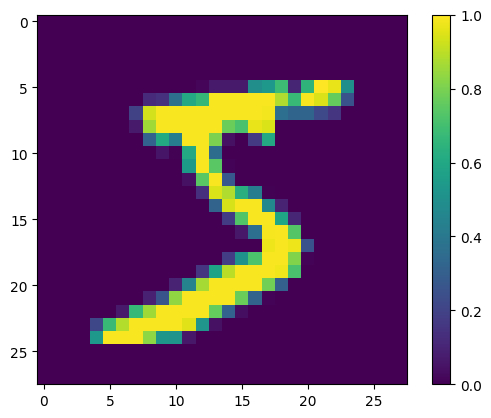

In [2]:
import torch
# torch.backends.cudnn.enabled = False
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

# generate the MNIST dataset
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])
mnist_dset = torchvision.datasets.MNIST("data/mnist", download=True, transform=transforms)
print(mnist_dset[0][0].shape)

# show a sample
# the first index is for the dataset, the second is for the tuple, the third one is for channel
plt.imshow(mnist_dset[0][0][0])
plt.colorbar()

## Fuck U-Net Score Network

In [3]:
class UNet(nn.Module):
    def __init__(self, n_channels=2, hid_channels=[32, 64, 128, 256, 256]):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.hid_channels = hid_channels
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(self.n_channels, self.hid_channels[0], kernel_size=3, padding=1),  # (B, C, 28, 28)
                nn.LogSigmoid(),    # (B, 8, 28, 28)
            ),
            nn.Sequential(
                nn.MaxPool2d(kernel_size=2, stride=2),  # (B, C, 14, 14)
                nn.Conv2d(self.hid_channels[0], self.hid_channels[1], kernel_size=3, padding=1),  # (B, C, 14, 14)
                nn.LogSigmoid(),    # (B, 16, 14, 14)
            ),
            nn.Sequential(
                nn.MaxPool2d(kernel_size=2, stride=2),  # (B, C, 7, 7)
                nn.Conv2d(self.hid_channels[1], self.hid_channels[2], kernel_size=3, padding=1),  # (B, C, 7, 7)
                nn.LogSigmoid(),    # (B, 32, 7, 7)
            ),
            nn.Sequential(
                nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # (B, C, 4, 4)
                nn.Conv2d(self.hid_channels[2], self.hid_channels[3], kernel_size=3, padding=1),  # (B, C, 4, 4)
                nn.LogSigmoid(),    # (B, 64, 4, 4)
            ),
            nn.Sequential(
                nn.MaxPool2d(kernel_size=2, stride=2),  # (B, C, 2, 2)
                nn.Conv2d(self.hid_channels[3], self.hid_channels[4], kernel_size=3, padding=1),  # (B, C, 2, 2)
                nn.LogSigmoid(),    # (B, 64, 2, 2)
            ),
        ])
        
        self.t_convs = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(self.hid_channels[4], self.hid_channels[3], kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 64, 4, 4)
                nn.LogSigmoid(), 
            ),
            nn.Sequential(
                nn.ConvTranspose2d(self.hid_channels[3] * 2, self.hid_channels[2], kernel_size=3, stride=2, padding=1, output_padding=0),  # (B, 32, 7, 7) 
                nn.LogSigmoid(), 
            ),
            nn.Sequential(
                nn.ConvTranspose2d(self.hid_channels[2] * 2, self.hid_channels[1], kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 16, 14, 14)
                nn.LogSigmoid(), 
            ),
            nn.Sequential(
                nn.ConvTranspose2d(self.hid_channels[1] * 2, self.hid_channels[0], kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 8, 28, 28)
                nn.LogSigmoid(), 
            ),
            nn.Sequential(
                nn.ConvTranspose2d(self.hid_channels[0] * 2, self.hid_channels[0], kernel_size=3, padding=1),  # (B, 2, 28, 28)
                nn.LogSigmoid(), 
                nn.Conv2d(self.hid_channels[0], 1, kernel_size=3, padding=1)    # (B, 1, 28, 28)
            ),
        ])
    
    def forward(self, x, t):
        # x: (..., ch0 * 28 * 28), t: (..., 1)
        x2 = torch.reshape(x, (*x.shape[:-1], 1, 28, 28))
        tt = t[..., None, None].expand(*t.shape[:-1], 1, 28, 28)
        x2t = torch.cat((x2, tt), dim=-3)
        signal = x2t
        signals = []
        
        for i, conv in enumerate(self.convs):
            signal = conv(signal)
            if i < len(self.convs) - 1:
                signals.append(signal)

        for i, tconv in enumerate(self.t_convs):
            if i == 0:
                signal = tconv(signal)
            else:
                signal = torch.cat((signal, signals[-i]), dim=-3)
                signal = tconv(signal)
        signal = torch.reshape(signal, (*signal.shape[:-3], -1))  # (..., 1 * 28 * 28)
        return signal


In [4]:
score_network = UNet()

## Fuck Score Matching Loss Function

<img src="assets/sde_schematic.jpg"  width="600" />

Score Function定义为对数概率密度函数对输入数据的梯度，也就是$\nabla_{\mathbf{x}}\log p(\mathbf{x})$。

Score Matching（分数匹配）类似于基于似然的估计模型，通过最小化模型和数据分布之间的Fisher散度来训练基于分数的模型。分数匹配目标可以直接在数据集上估计，并使用随机梯度下降进行优化，类似于训练基于似然模型的对数似然目标(具有已知的归一化常数)。我们可以通过最小化分数匹配目标来训练基于分数的模型，而不需要对抗性优化。

另外，这里我们使用了随机微分方程（SDE），即加入一些噪声扰动。通过将噪声尺度的数量推广到无穷大，我们不仅获得了更高质量的样本，而且还获得了精确的对数似然计算和逆问题求解的可控生成等。

$$
\mathcal{L}(\theta) = \int_0^1\lambda (t) \mathbb{E}_{\mathbf{x}(0)}\mathbb{E}_{\mathbf{x}(t)|\mathbf{x}(0)}\left[\left\lVert\mathbf{s}(\mathbf{x}(t), t; \theta) - \nabla_{\mathbf{x}(0)}\mathrm{log}\ p(\mathbf{x}(t)|\mathbf{x}(0))\right\rVert^2\right]\ dt
$$
where $\lambda(t)=1-\exp[-\int^t_0\beta(s)ds]$.

$$\begin{aligned}
\nabla_{\mathbf{x}(0)} \log p(\mathbf{x}(t) \mid \mathbf{x}(0)) & =-\frac{\mathbf{x}(t)-\boldsymbol{\mu}(t)}{\sigma^{2}(t)} \\
\boldsymbol{\mu}(t) & =\mathbf{x}(0) \exp \left[-\frac{1}{2} \int_{0}^{t} \beta(s) d s\right] \\
\sigma^{2}(t) & =1-\exp \left[-\int_{0}^{t} \beta(s) d s\right]
\end{aligned}$$



In [5]:
def calc_loss(score_network, x):
    # sample the time
    t = torch.rand((x.shape[0], 1), dtype=x.dtype, device=x.device) * (1 - 1e-4) + 1e-4

    # calculate the terms for the posterior log distribution
    int_beta = (0.1 + 0.5 * (20 - 0.1) * t) * t  # integral of beta
    mu_t = x * torch.exp(-0.5 * int_beta)
    var_t = -torch.expm1(-int_beta)
    x_t = torch.randn_like(x) * var_t ** 0.5 + mu_t
    grad_log_p = -(x_t - mu_t) / var_t  # (B, C)
    
    # calculate the score function
    score = score_network(x_t, t)  # score: (B, C)
    
    # calculate the loss function
    loss = (score - grad_log_p) ** 2
    lmbda_t = var_t
    weighted_loss = lmbda_t * loss
    return torch.mean(weighted_loss)


## Fuck Reverse SDE Sampling

朗之万动力学采样方法：该方法首先从先验分布随机采样一个初始样本，然后利用模型估计出来的分数逐渐将样本向数据分布的高概率密度区域靠近。

对于无限噪声尺度，我们可以通过使用逆SDE来类似地反转样本生成的扰动过程。

$$
\mathrm{d} \mathbf{x}=\left[\mathbf{f}(\mathbf{x}, t)-g(t)^{2} \mathrm{~s}(\mathbf{x}, t ; \theta)\right] \mathrm{d} t+g(t) \mathrm{d} \mathbf{w},
$$

where $\mathbf{f}(\mathbf{x}, t)=-\frac{1}{2}\beta(t)\mathbf x$, $g(t)=\sqrt{\beta(t)}$

In [6]:
def generate_samples(score_network, nsamples):
    device = next(score_network.parameters()).device
    x_t = torch.randn((nsamples, 28 * 28), device=device)  # (nsamples, nch)
    time_pts = torch.linspace(1, 0, 1000, device=device)  # (ntime_pts,)
    beta = lambda t: 0.1 + (20 - 0.1) * t
    for i in range(len(time_pts) - 1):
        t = time_pts[i]
        dt = time_pts[i + 1] - t

        # calculate the drift and diffusion terms
        fxt = -0.5 * beta(t) * x_t
        gt = beta(t) ** 0.5
        score = score_network(x_t, t.expand(x_t.shape[0], 1)).detach()
        drift = fxt - gt * gt * score
        diffusion = gt

        # euler-maruyama step
        x_t = x_t + drift * dt + diffusion * torch.randn_like(x_t) * torch.abs(dt) ** 0.5
    return x_t

## Train

In [7]:
# start the training loop
import time

opt = torch.optim.Adam(score_network.parameters(), lr=3e-4)
dloader = torch.utils.data.DataLoader(mnist_dset, batch_size=64, shuffle=True)
device = torch.device('cuda')
score_network = score_network.to(device)
t0 = time.time()
for i_epoch in range(400):
    total_loss = 0
    for data, _ in dloader:  # we don't need the data class
        data = data.reshape(data.shape[0], -1).to(device)
        opt.zero_grad()

        # training step
        loss = calc_loss(score_network, data)
        loss.backward()
        opt.step()

        # running stats
        total_loss = total_loss + loss.detach().item() * data.shape[0]

    # print the training stats
    if i_epoch % 20 == 0:
        print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(mnist_dset)}")

0 (17.36085271835327s): 0.23721743253072103
20 (325.5927369594574s): 0.02753624543448289
40 (623.4408187866211s): 0.02266096017062664
60 (919.57665848732s): 0.02032322556078434
80 (1215.874561548233s): 0.018808459504445395
100 (1513.3203694820404s): 0.018199041390419005
120 (1811.175273180008s): 0.017746802961826326
140 (2109.621108531952s): 0.017142087711393833
160 (2405.5918860435486s): 0.016966479088366033
180 (2703.499112844467s): 0.016740656012296677
200 (2998.808459997177s): 0.016622577727834383
220 (3295.630663871765s): 0.01630688250561555
240 (3594.494542360306s): 0.016429451052844525
260 (3894.505794763565s): 0.01607039536635081
280 (4190.237018823624s): 0.015885004195570946
300 (4487.782939910889s): 0.015612623732288678
320 (4786.916584730148s): 0.01572568452358246
340 (5084.233441829681s): 0.015510558115442594
360 (5383.283480167389s): 0.015694846826791762
380 (5683.143583059311s): 0.015698596585790318


In [8]:
samples = generate_samples(score_network, 20).detach().reshape(-1, 28, 28)

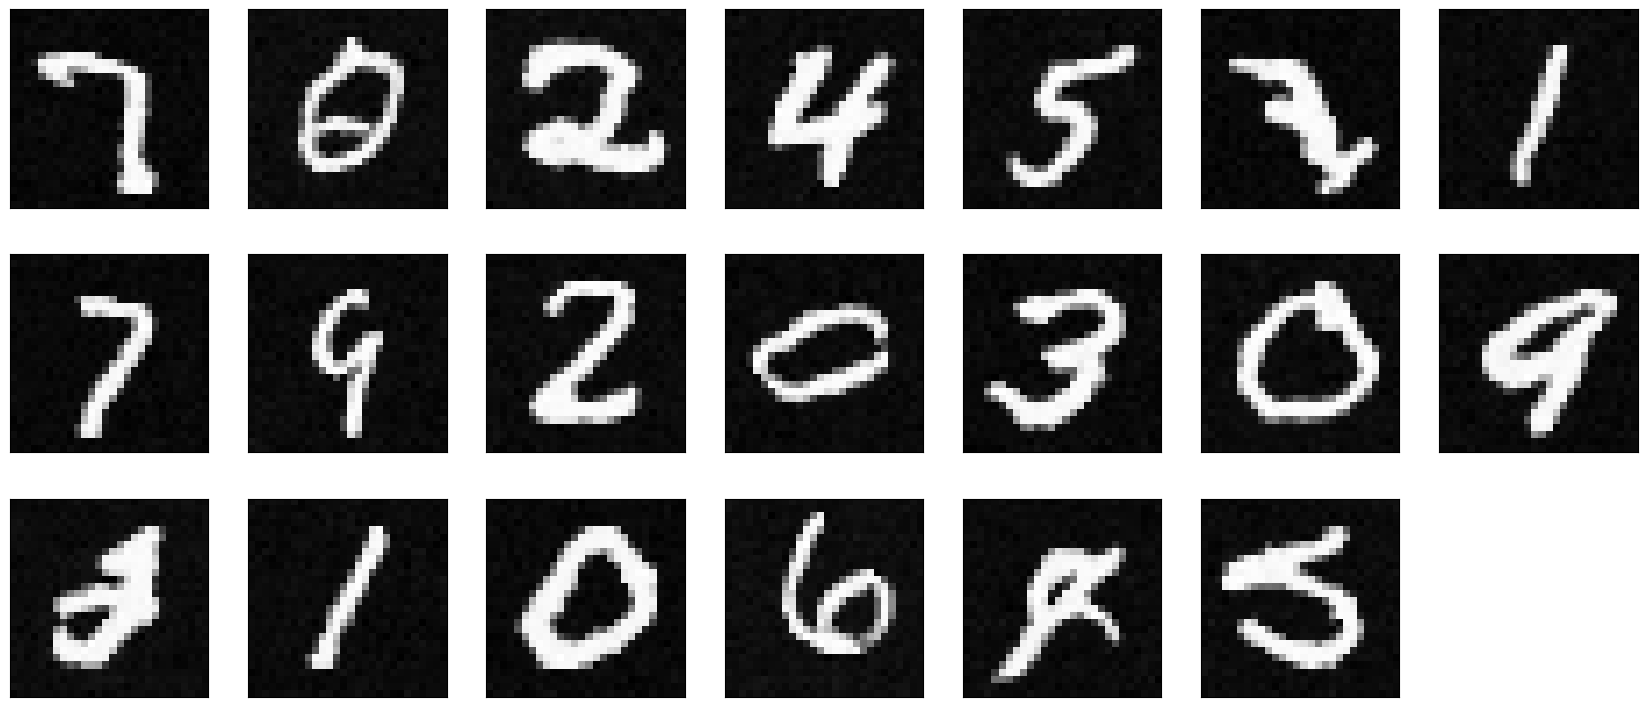

In [9]:
nrows, ncols = 3, 7
plt.figure(figsize=(3 * ncols, 3 * nrows))
for i in range(samples.shape[0]):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(1 - samples[i].detach().cpu().numpy(), cmap="Greys")
    plt.xticks([])
    plt.yticks([])